## Standard Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import heartpy as hp
from scipy.signal import resample
import janitor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',25)

sample_rate = 300

## 1. Data Exploration

In [2]:
dataset = pd.read_csv('E:\Competition\Flipr Hackathon XIII ML Task\ECG_training.csv')
dataset.shape

(3500, 2)

In [3]:
dataset.head()

,ECG,Classification
0,"-127,-162,-197,-229,-245,-254,-261,-265,-268,-...",N
1,"128,157,189,226,250,257,262,265,268,269,268,26...",N
2,"519,619,723,827,914,956,955,934,920,900,889,88...",A
3,"-266,-316,-367,-407,-423,-423,-401,-367,-329,-...",N
4,"21,22,24,26,28,31,32,34,34,35,35,34,34,34,35,3...",N


In [4]:
dataset['Classification'].value_counts()

N    3089
A     411
Name: Classification, dtype: int64

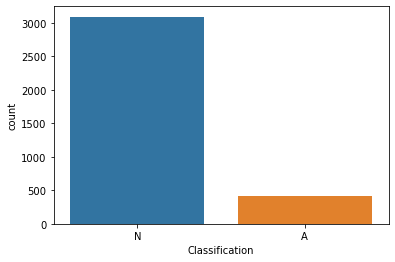

In [5]:
sns.countplot(dataset['Classification']);

#### The above plot suggests that the dataset is Imbalanced Dataset.

In [6]:
list_a = list(dataset[dataset['Classification'] == 'A'].index)

In [7]:
def splitter(series):
    data = series.str.split(',')
    data = data.apply(lambda x: list(map(int, x)))
    return data
    

In [8]:
dataset = (
    dataset.copy()
    .transform_column('ECG', splitter, elementwise=False)
)

## 2. Feature Extraction

**Steps:**
* The data we take for analysis is sliced off for first 2s essentially 28s of the data because some samples have unreal data in that range indicating the problem with the start of the sensor.
* The primary step would be to filter the data (performing notch as well as bandpass).
* The second step being scaling the data to keep every sample in the same range (optional).
* The third step takes into account of two steps:
    * First, inverting an inverted ECG signal.
    * Second, Resampling those samples which have more number of rejected peaks.
    * Third, retrieving the measures of time and frequency related domains of the samples.

In [25]:
# To know whether the sample is inverted, if so then we can invert the inverted signal
def non_inverted_ecg(arr):
    '''
    Comparing the difference of height between the mean of the signal and the peak of the inverted and non-inverted signals
    Intuition: Non-inverted signals will have more difference of height than inverted signal because of the nature
    of the QRS complex.
    
    '''

    num_samples = 5
    count_nos = 0
    num_normal = []
    num_inv = []
    
    nor_wd, nor_m = hp.process(arr, sample_rate=sample_rate, calc_freq=True, bpmmin=20, bpmmax=180)
    for i in random.sample(list(nor_wd['peaklist']), k=num_samples):
        mean = nor_wd['hr'].mean()
        num_normal.append(nor_wd['hr'][i] - mean)
    mean_num_normal = np.array(num_normal).mean()
    
    inv_wd, inv_m = hp.process(hp.flip_signal(arr), sample_rate=sample_rate, calc_freq=True, bpmmin=20, bpmmax=180)
    for i in random.sample(list(inv_wd['peaklist']), k=num_samples):
        mean = inv_wd['hr'].mean()
        num_inv.append(inv_wd['hr'][i] - mean)
    mean_num_inv = np.array(num_inv).mean()
    
     
    if mean_num_normal > mean_num_inv:
        if len(nor_wd['removed_beats']) > 5:
            resampled_signal = resample(arr, len(arr) * 6)
            nor_wd, nor_m = hp.process(hp.scale_data(resampled_signal), sample_rate * 6, calc_freq=True, bpmmin=20, bpmmax=180)
        return nor_wd, nor_m
    else:
        if len(inv_wd['removed_beats']) > 5:
            resampled_signal = resample(arr, len(arr) * 6)
            inv_wd, inv_m = hp.process(hp.scale_data(resampled_signal), sample_rate * 6, calc_freq=True, bpmmin=20, bpmmax=180)
        return inv_wd, inv_m

#     '''Setting the threshold as only 80% of the peaks to neglect some random peaks'''
#     if count_nos > 0.8*num_samples:
#         return nor_wd, nor_m
#     else:
#         return inv_wd, inv_m

In [26]:
# 1892,2325 have inverted ECG signal
# 37,708, 945 is the most problamatic
# Should do filtering(notch) followed by scaling
def features(series):
    count=0
    cols = ['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate',
           'vlf', 'lf', 'hf', 'lf/hf', 'p_total', 'vlf_perc', 'lf_perc', 'hf_perc', 'lf_nu', 'hf_nu']
    df = pd.DataFrame(columns=cols)
    for arr in series:
        arr = hp.filter_signal(arr[600::], cutoff=0.05, sample_rate=sample_rate, filtertype='notch')
#         arr = hp.filter_signal(arr, cutoff=(0.33,3), sample_rate=sample_rate, filtertype='bandpass')
        arr = hp.scale_data(arr)
        wd, m = non_inverted_ecg(arr)
        df.loc[count] = m
        count += 1
    return df

In [27]:
%%time
df = features(dataset['ECG'])

Wall time: 5min 20s


In [28]:
df['Classification'] = dataset['Classification']

In [29]:
df

,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,vlf,lf,hf,lf/hf,p_total,vlf_perc,lf_perc,hf_perc,lf_nu,hf_nu,Classification
0,78.612428,763.238095,32.848722,11.001817,21.213203,0.352941,0.000000,30.000000,14.942058,43.783539,2055.280701,0.341271,0.299558,0.0,86.614762,172.616026,0.501777,259.230788,0.0,33.412220,66.587780,33.412220,66.587780,N
1,69.186419,867.222222,162.635034,186.111111,267.556963,0.500000,0.500000,3.055556,135.921637,131.600429,56194.753777,1.032836,0.288517,0.0,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,N
2,64.404983,931.604938,172.742036,136.380253,222.444999,0.920000,0.800000,123.333333,157.237655,186.234404,91995.449057,0.844300,0.198855,0.0,3288.545748,17098.709464,0.192327,20387.255213,0.0,16.130400,83.869600,16.130400,83.869600,A
3,57.121933,1050.384615,38.975413,18.36712,30.433899,0.560000,0.080000,26.666667,21.038800,44.096460,2914.570509,0.477109,0.183143,0.0,28.667866,215.987689,0.132729,244.655555,0.0,11.717644,88.282356,11.717644,88.282356,N
4,62.831006,954.942529,50.466184,19.446347,29.202359,0.428571,0.071429,43.333333,20.461477,68.042510,4373.883224,0.300716,0.144493,0.0,1149.713023,89.424585,12.856789,1239.137608,0.0,92.783321,7.216679,92.783321,7.216679,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,88.073394,681.250000,62.497500,65.51013,74.133167,0.410256,0.102564,35.000000,52.346293,70.436841,11583.389889,0.743166,0.110140,0.0,502.923110,1297.846995,0.387506,1800.770105,0.0,27.928224,72.071776,27.928224,72.071776,N
3496,73.539425,815.888889,17.377792,9.035079,14.198144,0.142857,0.000000,11.666667,10.038192,20.289850,639.858906,0.494740,0.326958,0.0,40.978127,46.495530,0.881335,87.473657,0.0,46.846249,53.153751,46.846249,53.153751,N
3497,63.535162,944.358974,55.483648,14.455124,26.509956,0.458333,0.041667,31.666667,18.480053,73.760331,4282.288606,0.250542,0.244459,0.0,396.919863,228.657090,1.735874,625.576953,0.0,63.448607,36.551393,63.448607,36.551393,N
3498,82.681564,725.675676,47.778674,8.511974,15.122953,0.194444,0.000000,23.333333,10.567529,66.542419,2209.133203,0.158809,0.186331,0.0,85.915074,168.677320,0.509346,254.592394,0.0,33.746128,66.253872,33.746128,66.253872,N


## 3. Model Preparation

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold

### 3.1 Splitting the dataset

In [124]:
RANDOM_STATE = 0

In [125]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cols = df.drop('Classification', axis=1).columns
X = df.drop('Classification', axis=1).to_numpy()
y = df['Classification']

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)
y_train = pd.get_dummies(y_train)['A']
y_test = pd.get_dummies(y_test)['A']

### 3.2 Model Pipeline

In [154]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, accuracy_score, recall_score

In [128]:
svm_ppln = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('SVM', SVC())
    
])

svm_ppln.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('SVM', SVC())])

In [159]:
y_pred = svm_ppln.predict(X_test)

f1_score(y_test, y_pred)

0.0

In [161]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       617
           1       0.00      0.00      0.00        83

    accuracy                           0.88       700
   macro avg       0.44      0.50      0.47       700
weighted avg       0.78      0.88      0.83       700



In [141]:
from sklearn.tree import DecisionTreeClassifier

In [172]:
dt_ppln = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('dt', DecisionTreeClassifier())
])

dt_ppln.fit(X_train, y_train)

y_pred = dt_ppln.predict(X_test)

print('Decision Tree')
print('F1-Score: ',f1_score(y_test, y_pred))
print('Recall Score: ', recall_score(y_test, y_pred))
print('Classification Report: \n',classification_report(y_test, y_pred))

Decision Tree
F1-Score:  0.8176100628930818
Recall Score:  0.7831325301204819
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       617
           1       0.86      0.78      0.82        83

    accuracy                           0.96       700
   macro avg       0.91      0.88      0.90       700
weighted avg       0.96      0.96      0.96       700



In [176]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(n_estimators=100))
])

rfc.fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print('RandomForest')
print('F1-Score: ',f1_score(y_test, y_pred))
print('Recall Score: ', recall_score(y_test, y_pred))
print('Classification Report: \n',classification_report(y_test, y_pred))

RandomForest
F1-Score:  0.8176100628930818
Recall Score:  0.7831325301204819
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       617
           1       0.86      0.78      0.82        83

    accuracy                           0.96       700
   macro avg       0.91      0.88      0.90       700
weighted avg       0.96      0.96      0.96       700

